# Benchmark between Matlab and Python implementation of DEPSI spatial unwrapping

We will construct a network with pnts and arcs from matlab data.

The relevant data we are using from MATLAB are:

Inputs:
- arc ambiguities
- source and destination point indices for arcs
- point azimuth and range indices, order matters since it connects to arcs
- reference point id
- ref point azimuth and range

Outputs:
- point ambiguities

Now arc estimation happens in this process, so theoretically pnts and arcs phases should not matter.

In [1]:
import xarray as xr
import numpy as np
import scipy
import math
from matplotlib import pyplot as plt

# import matplotlib.cm as cm
import matplotlib.colors as plc

from depsi.network import (
    spatial_unwrapping,
    _network_relation_matrix,
)

WAVELENGTH = 0.055465763  # Sentinel-1, in meters

In [2]:
# Matlab files
file_mat_input = "../../data/marken_tsx_testdata_spatial_integration/marken_tsx_spatial_unwrapping_testdata_input.mat"
file_mat_output = "../../data/marken_tsx_testdata_spatial_integration/marken_tsx_spatial_unwrapping_testdata_output.mat"
data_input = scipy.io.loadmat(file_mat_input)
data_output = scipy.io.loadmat(file_mat_output)

In [3]:
data_input.keys()

dict_keys(['__header__', '__version__', '__globals__', 'atmo_range', 'defo_range', 'detail_plots', 'detrend_flag', 'fig', 'max_mem_buffer', 'orbit', 'ps_eval_method', 'sat_vel', 'visible_plots', 'ens_coh_threshold', 'varfac_threshold', 'ref_cn', 'Nifgs', 'Npsc', 'Npsc_selections', 'Nref', 'Narcs', 'Btemp', 'Bdop', 'final_model', 'std_param', 'sig2_est', 'breakpoint', 'breakpoint2', 'network_flag', 'z', 'final_althyp_index', 'removed_points_flag', 'ans', 'fid_res', 'project_id', 'fullscreen', 'Npixels', 'Nlines', 'minratio', 'ratio_index', 'figpos', 'separate_flag', 'dpsc_fid', 'dpsc_arcs', 'dpsc_phase', 'dpsc_h2ph', 'dpsc_results_fid', 'Npar_max', 'dpsc_param', 'dpsc_ens_coh', 'dpsc_acheck', 'dpsc_model_info', 'dpsc_varfac_best', 'psc_fid', 'psc_data', 'psc_array_in', 'psc_az', 'psc_r', 'psc_h2ph', 'ps_method', 'unwrap_istep', 'unwrap2_istep', 'results_id', 'az_spacing', 'r_spacing', 'weighted_unwrap', 'run_mode', 'defo_model_flag', 'weighting', 'm2ph'])

In [4]:
data_output.keys()

dict_keys(['__header__', '__version__', '__globals__', 'atmo_range', 'defo_range', 'detail_plots', 'detrend_flag', 'fig', 'max_mem_buffer', 'orbit', 'ps_eval_method', 'sat_vel', 'visible_plots', 'ens_coh_threshold', 'varfac_threshold', 'ref_cn', 'Nifgs', 'Npsc', 'Npsc_selections', 'Nref', 'Narcs', 'Btemp', 'Bdop', 'final_model', 'std_param', 'sig2_est', 'breakpoint', 'breakpoint2', 'network_flag', 'z', 'final_althyp_index', 'removed_points_flag', 'ans', 'fid_res', 'project_id', 'fullscreen', 'Npixels', 'Nlines', 'minratio', 'ratio_index', 'figpos', 'separate_flag', 'dpsc_fid', 'dpsc_arcs', 'dpsc_phase', 'dpsc_h2ph', 'dpsc_results_fid', 'Npar_max', 'dpsc_param', 'dpsc_ens_coh', 'dpsc_acheck', 'dpsc_model_info', 'dpsc_varfac_best', 'psc_fid', 'psc_data', 'psc_array_in', 'psc_az', 'psc_r', 'psc_h2ph', 'ps_method', 'low_coh', 'dpsc_arcs_removed1', 'dpsc_arcs_orig', 'Narcs_new', 'unwrap_istep', 'unwrap2_istep', 'exit_flag', 'dpsc_arcs_removed2', 'psc', 'Npsc_connections', 'v', 'index_cns', 

In [166]:
data_output['Qyy_diag'].todense()

matrix([[0.26681094],
        [0.19508558],
        [0.14527694],
        [0.13296905],
        [0.07453513],
        [0.10882424],
        [0.13944614],
        [0.13632956],
        [0.09264398],
        [0.02993899],
        [0.03958398],
        [0.05881126],
        [0.18660168],
        [0.25360672],
        [0.17953232],
        [0.04968088],
        [0.0522721 ],
        [0.05229819],
        [0.0336497 ],
        [0.04974881],
        [0.07166992],
        [0.1047533 ],
        [0.04810785],
        [0.07105581],
        [0.07549299],
        [0.09607773],
        [0.08895517],
        [0.07520229],
        [0.06910254],
        [0.1019185 ],
        [0.02444576],
        [0.07213651],
        [0.06778759],
        [0.02905262],
        [0.05059616],
        [0.04709652],
        [0.05251846],
        [0.05420675],
        [0.08441891],
        [0.16224601],
        [0.1303702 ],
        [0.05146021],
        [0.04866583],
        [0.03716582],
        [0.0395452 ],
        [0

In [5]:
# Input data
azimuth_idx = data_input["psc_data"][:, 4] # azimuth index
range_idx = data_input["psc_data"][:, 5] # range index
Btemp = data_input["Btemp"].squeeze()
pnt_phase = data_input["psc_data"][:, 6:6+data_input["Btemp"].shape[0]]
pnt_h2ph = data_input["psc_data"][:,(6+data_input["Btemp"].shape[0]):(6+2*data_input["Btemp"].shape[0])]
arc_h2ph = data_input["dpsc_h2ph"] # arc h2ph values
arc_phases = data_input["dpsc_phase"] # arc phase values
arc_ens_coh = data_input["dpsc_ens_coh"].squeeze() # arc ensemble coherence
arc_acheck = data_input["dpsc_acheck"]
Narcs = data_input["Narcs"].squeeze()
idx_source = data_input["dpsc_arcs"][:, 0]-1 # MATLAB to Python index
idx_target = data_input["dpsc_arcs"][:, 1]-1 # MATLAB to Python index

# reference point, this is taken from output data
idx_ref_pnt = data_output["ref_array"][0][0] - 1 # MATLAB to Python index 
refpnt_azimuth = data_output["ref_array"][0][1]
refpnt_range = data_output["ref_array"][0][2]

# Processing parameters
ens_coh_threshold = data_input["ens_coh_threshold"][0][0] # arc selection threshold

In [ ]:
# Assign ambiguity results to original points array
acheck = data_output["acheck"]
idx_nonref_pnts = data_output["non_ref_points"].squeeze()-1

### Validation 1: check the network constructed from MATLAB data, see if the souce and target points are correctly mapped.

In [ ]:
# Points stm as xr dataset with space and time dimensions
stm = xr.Dataset(
    data_vars={
        "pnt_h2ph": (("space", "time"), pnt_h2ph),
        "pnt_phase": (("space", "time"), pnt_phase),
    },
    coords={
        "time": (("time"), Btemp),
        "space": (("space"), np.arange(azimuth_idx.shape[0])),
        "azimuth": (("space"), azimuth_idx),
        "range": (("space"), range_idx),
    },
)
stm

<xarray.Dataset> Size: 2MB
Dimensions:    (space: 271, time: 359)
Coordinates:
  * space      (space) int64 2kB 0 1 2 3 4 5 6 7 ... 264 265 266 267 268 269 270
  * time       (time) float64 3kB -8.167 -8.137 -8.107 ... 5.877 5.907 5.937
    azimuth    (space) float64 2kB 35.0 35.0 107.0 ... 2.051e+03 2.058e+03
    range      (space) float64 2kB 315.0 688.0 693.0 684.0 ... 384.0 460.0 579.0
Data variables:
    pnt_h2ph   (space, time) float64 778kB 0.001356 4.448e-05 ... -0.0002177
    pnt_phase  (space, time) float64 778kB 0.3294 -3.001 2.89 ... -2.475 1.463

In [8]:
# Manually assign a uid
scale = 10 ** (math.floor(math.log10(stm.sizes["space"])) + 1)  # Scale to ensure no overlap
uid = scale * (idx_source + 1) + (idx_target + 1)  # Plus one to avoid zero uid
uid = uid.astype(np.int64)

stm_arcs = xr.Dataset(
    data_vars={
        "h2ph": (("space", "time"), arc_h2ph),
        "ambiguities": (("space", "time"), arc_acheck),
        "ens_coh": (("space"), arc_ens_coh),
        "d_phase": (("space", "time"), arc_phases),
        "uid": (("space"), uid),
    },
    coords={
        "time": (("time"), Btemp),
        "source": (("space"), idx_source),
        "target": (("space"), idx_target),
    },
)
stm_arcs

<xarray.Dataset> Size: 7MB
Dimensions:      (space: 797, time: 359)
Coordinates:
  * time         (time) float64 3kB -8.167 -8.137 -8.107 ... 5.877 5.907 5.937
    source       (space) uint16 2kB 0 0 0 0 0 1 1 ... 266 266 267 267 268 269
    target       (space) uint16 2kB 1 2 3 6 14 2 4 ... 269 270 268 269 269 270
Dimensions without coordinates: space
Data variables:
    h2ph         (space, time) float64 2MB 0.001355 4.472e-05 ... -0.0002178
    ambiguities  (space, time) float64 2MB -17.0 -17.0 -16.0 ... -1.0 0.0 0.0
    ens_coh      (space) float64 6kB 0.1747 0.1696 0.163 ... 0.8257 0.8315
    d_phase      (space, time) float64 2MB 2.361 3.392 -5.502 ... -0.8651 -1.176
    uid          (space) int64 6kB 1002 1003 1004 1007 ... 6125 6126 7126 8127

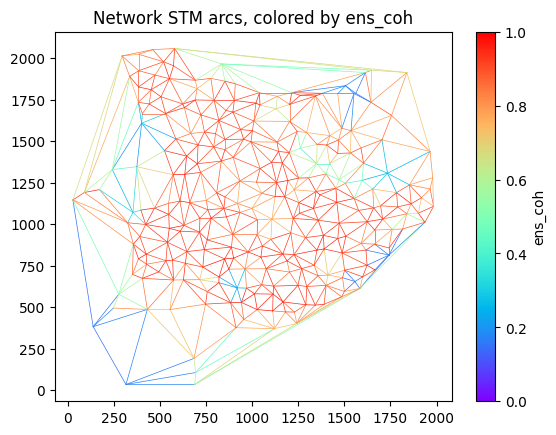

In [167]:
# x of sources and targets
xx = np.stack(
    [
        stm.isel(space=stm_arcs["source"])["range"].values,
        stm.isel(space=stm_arcs["target"])["range"].values,
    ]
).T
# y of sources and targets
yy = np.stack(
    [
        stm.isel(space=stm_arcs["source"])["azimuth"].values,
        stm.isel(space=stm_arcs["target"])["azimuth"].values,
    ]
).T
# Visualize created arcs
fig, ax = plt.subplots()
cmap = plt.cm.rainbow
norm = plc.Normalize(vmin=0, vmax=1.0)
mean_nmad = np.abs(stm_arcs["ens_coh"].data)
for i in range(stm_arcs.sizes["space"]):
    ax.plot(xx[i], yy[i], color=cmap(norm(mean_nmad[i])), linewidth=0.5)
plt.title("Network STM arcs, colored by ens_coh")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="ens_coh")

### Validation 2: check if the point ambiguity estimation gives small residuals when plugged back to arcs.



In [159]:
# Network relation matrix A with all original points except the reference point
arc_idx_selected = np.where(np.isin(idx_source, idx_nonref_pnts) & np.isin(idx_target, idx_nonref_pnts))[0]
A = _network_relation_matrix(
    stm_arcs["source"].values[arc_idx_selected],
    stm_arcs["target"].values[arc_idx_selected],
    stm.sizes["space"],
    idx_ref_pnt
).todense()

# Insert a column of zeros to A at idx_ref_pnt
A_with_ref = np.insert(A, idx_ref_pnt, 0, axis=1)

A_selected = A_with_ref[:, idx_nonref_pnts]
A_selected

matrix([[-1,  0,  0, ...,  0,  0,  0],
        [-1,  0,  0, ...,  0,  0,  0],
        [ 0, -1,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  1,  0],
        [ 0,  0,  0, ..., -1,  1,  0],
        [ 0,  0,  0, ...,  0, -1,  1]], shape=(585, 232), dtype=int8)

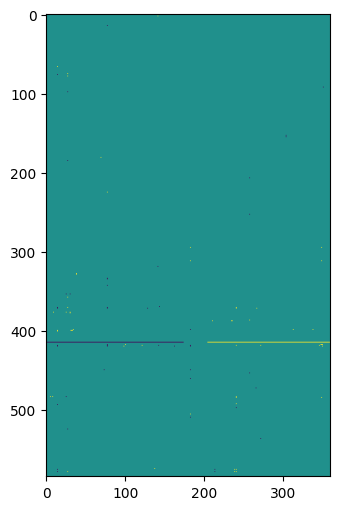

In [ ]:
# Compute arc residuals
# The expectation is that for most of the arcs, the residual should be close to zero
# Except for those arcs which were rejected in MHT processes
arc_residual = A_selected @ np.round(acheck) - arc_acheck[arc_idx_selected,:]
plt.figure(figsize=(10, 6))
plt.imshow(arc_residual, vmin=-1, vmax=1)

# Almost all zeros. Maybe something wrong with the reference point handling?

## Perform spatial unwrapping to compute point ambiguities from arc ambiguities

In [168]:
Qyy_diag = np.ones(stm_arcs.sizes["space"])

stm_arcs_output, stm_pnts_output = spatial_unwrapping(
    stm, stm_arcs, Qyy_diag, threshold_arc_quality=ens_coh_threshold, idx_refpnt=idx_ref_pnt
)

/home/oku/Developments/MobyLe/DePSI_group/depsi/mht_utils.py:255: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  lambda_init = fsolve(lambda lambda_init: _lambda_approx(lambda_init, df, gam0, cv), lstrt)


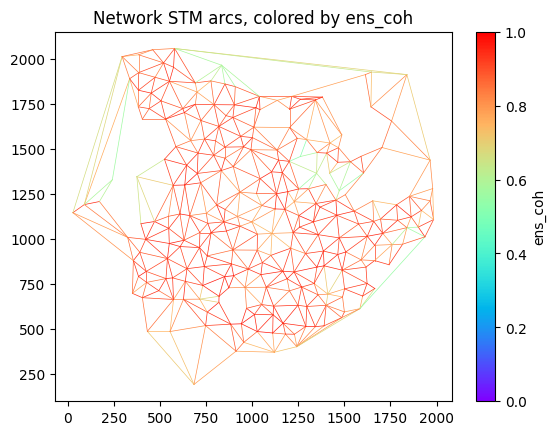

In [177]:
# x of sources and targets
xx = np.stack(
    [
        stm_pnts_output.isel(space=stm_arcs_output["source"])["range"].values,
        stm_pnts_output.isel(space=stm_arcs_output["target"])["range"].values,
    ]
).T
# y of sources and targets
yy = np.stack(
    [
        stm_pnts_output.isel(space=stm_arcs_output["source"])["azimuth"].values,
        stm_pnts_output.isel(space=stm_arcs_output["target"])["azimuth"].values,
    ]
).T
# Visualize created arcs
fig, ax = plt.subplots()
cmap = plt.cm.rainbow
norm = plc.Normalize(vmin=0, vmax=1.0)
mean_nmad = np.abs(stm_arcs_output["ens_coh"].data)
for i in range(stm_arcs_output.sizes["space"]):
    ax.plot(xx[i], yy[i], color=cmap(norm(mean_nmad[i])), linewidth=0.5)
plt.title("Network STM arcs, colored by ens_coh")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="ens_coh")

In [ ]:
plt.imshow(stm_pnts_output["ambiguities"].values, cmap="jet", vmin=-2, vmax=2)

In [ ]:
plt.imshow(acheck, cmap="jet", vmin=-2, vmax=2)

### Post validation 1: check arc residuals of Python solution

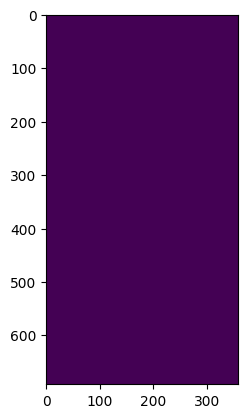

In [179]:
A = _network_relation_matrix(
    stm_arcs_output["source"].values,
    stm_arcs_output["target"].values,
    stm_pnts_output.sizes["space"]+1,
    stm_pnts_output.sizes["space"]
).todense()

# Plot residuals
arc_residual = A @ stm_pnts_output["ambiguities"].values - stm_arcs_output["ambiguities"].values
plt.imshow(arc_residual)

### Post validation 2: Seclect same points as MATLAB solution by radar coordinates and compare point ambiguities of Python and MATLAB solutions